In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)


training_set = data.iloc[0:325 - 50, : ].values  # 前(325-50=275)天的数据作为训练集,表格从0开始计数
test_set = data.iloc[325 - 50: , : ].values  # 后50天的数据作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled_x = sc_x.fit_transform(training_set[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
training_set_scaled_y = sc_y.fit_transform(training_set[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_x = sc_x.transform(test_set[:,2:])  # 利用训练集的属性对测试集进行归一化
test_set_y = sc_y.transform(test_set[:,1:2])  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前325-50=275个数据
# 利用for循环，遍历整个训练集，提取训练集中连续5天的26个降维新变量作为输入特征x_train，第6天的RON_LOSS作为标签，for循环共构建325-50-5=270组数据。

for i in range(5, len(training_set_scaled_x)):
    x_train.append(training_set_scaled_x[i - 5:i, :])
    y_train.append(training_set_scaled_y[i, :])

# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即270组数据；输入连续5个的26个降维新变量，预测出第6天的RON_LOSS，循环核时间展开步数为5; 每个时间步送入的特征是连续5天的26个降维新变量，有26个数据，故每个时间步输入特征个数为26
x_train = np.reshape(x_train, (x_train.shape[0], 5, 26))
# 测试集：csv表格中后50天数据
# 利用for循环，遍历整个测试集，提取测试集中连续5天的26个降维新变量作为输入特征x_train，第6天的数据作为RON_LOSS，for循环共构建50-5=45组数据。
for i in range(5, len(test_set)):
    x_test.append(test_set_x[i - 5 : i, :])
    y_test.append(test_set_y[i, :])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))

model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
#C:\Users\Administrator\Desktop\
checkpoint_save_path = r"C:\Users\Administrator\Desktop\RNNcheckpoint\RNN_RON_LOSS.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

-------------load the model-----------------
Train on 270 samples, validate on 45 samples
Epoch 1/50
270/270 [==============================] - 2s 9ms/sample - loss: 0.0624 - val_loss: 0.0199
Epoch 2/50
270/270 [==============================] - 0s 193us/sample - loss: 0.0613 - val_loss: 0.0208
Epoch 3/50
270/270 [==============================] - 0s 193us/sample - loss: 0.0578 - val_loss: 0.0235
Epoch 4/50
270/270 [==============================] - 0s 211us/sample - loss: 0.0593 - val_loss: 0.0303
Epoch 5/50
270/270 [==============================] - 0s 207us/sample - loss: 0.0764 - val_loss: 0.0225
Epoch 6/50
270/270 [==============================] - 0s 200us/sample - loss: 0.0659 - val_loss: 0.0217
Epoch 7/50
270/270 [==============================] - 0s 928us/sample - loss: 0.0670 - val_loss: 0.0164
Epoch 8/50
270/270 [==============================] - 0s 788us/sample - loss: 0.0636 - val_loss: 0.0159
Epoch 9/50
270/270 [==============================] - 0s 818us/sample - loss: 0.

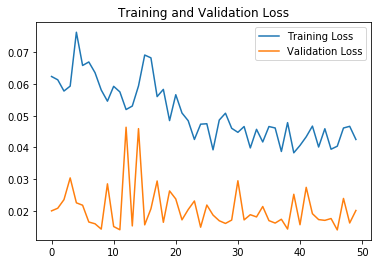

In [9]:
file = open('C:/Users/Administrator/Desktop/RNN_RON_LOSS_weights.txt', 'w' )  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
################## predict ######################
# 测试集输入模型进行预测
predicted_RON_LOSS = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_RON_LOSS = sc_y.inverse_transform(y_test)
# 画出真实数据和预测数据的对比曲线
plt.plot(real_RON_LOSS, color='red', label=' realed RON LOSS')
plt.plot(predicted_RON_LOSS, color='blue', label='Predicted RON LOSS')
plt.title('RON LOSS Prediction')
plt.xlabel('Time')
plt.ylabel('RON LOSS')
plt.legend()
plt.show()

In [11]:
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_RON_LOSS, real_RON_LOSS)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_RON_LOSS, real_RON_LOSS))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_RON_LOSS, real_RON_LOSS)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.051365
均方根误差: 0.226638
平均绝对误差: 0.181385


In [6]:
predicted_RON_LOSS.shape

(45, 1)

In [ ]:
################## predict ######################
# 测试集输入模型进行预测
predicted_RON_LOSS = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_RON_LOSS = sc_y.inverse_transform(y_test)
# 画出真实数据和预测数据的对比曲线
plt.plot(real_RON_LOSS, color='red', label=' realed RON LOSS')
plt.plot(predicted_RON_LOSS, color='blue', label='Predicted RON LOSS')
plt.title('RON LOSS Prediction')
plt.xlabel('Time')
plt.ylabel('RON LOSS')
plt.legend()
plt.show()

In [45]:
data.head(10)

,id,P_RON_LOSS,var1,var2,var3,var4,var5,var6,var7,var8,...,var7.1,var18,var19,var20,var21,var22,var23,var24,var25,var26
324,325,1.3,1.840000e+19,1.210000e+20,1.160000e+20,-2.800000e+18,2.330000e+18,-1.040000e+18,1.030000e+19,-4.620000e+18,...,5.260000e+16,9.760400e+15,1.470000e+17,1.787210e+15,9.000000e+16,-7.180000e+16,7.170000e+16,7.910000e+16,8.542870e+15,3.683360e+15
323,324,1.3,2.000000e+19,1.210000e+20,1.170000e+20,-3.380000e+18,1.890000e+18,-8.670000e+17,8.570000e+18,-3.840000e+18,...,3.500000e+16,6.802460e+15,7.600000e+16,5.231830e+14,4.030000e+16,-3.040000e+16,2.680000e+16,3.060000e+16,4.081970e+15,-4.772460e+14
322,323,1.3,2.180000e+19,1.210000e+20,1.180000e+20,-3.970000e+18,1.440000e+18,-6.910000e+17,6.820000e+18,-3.050000e+18,...,1.550000e+16,3.206470e+15,1.390000e+16,-2.542180e+14,3.624790e+14,1.861910e+15,-8.154000e+15,-8.009820e+15,-1.223420e+15,-1.008900e+15
321,322,1.3,2.440000e+19,1.220000e+20,1.200000e+20,-4.860000e+18,7.570000e+17,-4.100000e+17,4.150000e+18,-1.860000e+18,...,-5.700230e+15,-3.404540e+14,-5.540000e+16,-2.953000e+14,-4.010000e+16,3.830000e+16,-4.070000e+16,-4.880000e+16,-8.321100e+15,-1.495350e+15
320,321,1.1,2.610000e+19,1.220000e+20,1.210000e+20,-5.470000e+18,2.930000e+17,-2.250000e+17,2.350000e+18,-1.050000e+18,...,-2.290000e+16,-4.244970e+15,-8.490000e+16,5.851370e+14,-5.620000e+16,5.020000e+16,-5.220000e+16,-5.970000e+16,-7.327770e+15,-6.012360e+14
319,320,1.3,2.790000e+19,1.220000e+20,1.220000e+20,-6.080000e+18,-1.760000e+17,-3.250000e+16,5.240000e+17,-2.440000e+17,...,-3.310000e+16,-6.219840e+15,-1.040000e+17,1.394110e+15,-6.140000e+16,5.390000e+16,-5.220000e+16,-6.160000e+16,-8.138490e+15,-7.806860e+14
318,319,1.1,3.060000e+19,1.230000e+20,1.230000e+20,-7.010000e+18,-8.890000e+17,2.520000e+17,-2.240000e+18,9.970000e+17,...,-5.280000e+16,-1.120000e+16,-1.110000e+17,-6.404390e+14,-5.570000e+16,4.020000e+16,-3.250000e+16,-3.660000e+16,-3.584960e+15,3.100130e+14
317,318,1.3,3.240000e+19,1.230000e+20,1.240000e+20,-7.630000e+18,-1.370000e+18,4.390000e+17,-4.090000e+18,1.840000e+18,...,-6.550000e+16,-1.480000e+16,-1.030000e+17,-3.073930e+15,-4.140000e+16,1.700000e+16,-6.055490e+15,-2.794720e+15,1.418360e+15,1.128650e+15
316,317,1.1,3.420000e+19,1.230000e+20,1.260000e+20,-8.270000e+18,-1.860000e+18,6.300000e+17,-5.960000e+18,2.690000e+18,...,-7.870000e+16,-1.890000e+16,-8.250000e+16,-5.379100e+15,-1.720000e+16,-1.520000e+16,3.080000e+16,4.230000e+16,7.089080e+15,2.750500e+15
315,316,1.1,3.690000e+19,1.230000e+20,1.270000e+20,-9.060000e+18,-2.550000e+18,9.020000e+17,-8.770000e+18,3.980000e+18,...,-3.740000e+16,-9.179570e+15,2.020960e+13,-1.750000e+16,1.500000e+16,-6.400000e+16,1.120000e+17,1.760000e+17,6.930000e+16,-4.420000e+16


In [39]:
data.tail()

,id,P_RON_LOSS,var1,var2,var3,var4,var5,var6,var7,var8,...,var7.1,var18,var19,var20,var21,var22,var23,var24,var25,var26
4,5,1.3,-5.060000e+19,-8.560000e+19,4.240000e+19,1.580000e+19,-2.050000e+18,4.430000e+18,1.300000e+18,1.600000e+18,...,4.530000e+16,1.430000e+16,8.187380e+15,-1.130000e+16,1.730000e+16,2.280000e+16,-1.560000e+16,6.431420e+15,2.380000e+16,3.325610e+15
3,4,1.4,-4.960000e+19,-8.660000e+19,4.300000e+19,1.610000e+19,-2.070000e+18,4.640000e+18,1.310000e+18,1.610000e+18,...,4.860000e+16,1.140000e+16,1.220000e+16,-7.095370e+15,1.990000e+16,2.300000e+16,-2.220000e+16,6.558510e+15,3.270000e+16,4.738870e+15
2,3,1.4,-4.740000e+19,-8.910000e+19,4.440000e+19,1.660000e+19,-2.090000e+18,5.120000e+18,1.310000e+18,1.590000e+18,...,5.850000e+16,4.236000e+15,1.510000e+16,-1.143890e+15,3.070000e+16,1.830000e+16,-3.950000e+16,4.190650e+15,5.770000e+16,6.167660e+15
1,2,1.2,-4.640000e+19,-9.020000e+19,4.500000e+19,1.680000e+19,-2.100000e+18,5.320000e+18,1.320000e+18,1.590000e+18,...,6.250000e+16,3.374480e+15,1.570000e+16,1.174930e+14,3.520000e+16,1.690000e+16,-4.600000e+16,3.607790e+15,6.620000e+16,6.350950e+15
0,1,1.4,-4.410000e+19,-9.270000e+19,4.640000e+19,1.740000e+19,-2.110000e+18,5.750000e+18,1.290000e+18,1.530000e+18,...,5.790000e+16,1.130000e+16,-2.847480e+15,-6.094000e+15,5.750000e+16,-8.061590e+15,-5.820000e+16,-6.786400e+15,8.110000e+16,2.882050e+15


In [42]:
for i in range(10,0,-1):
    print(i)

In [48]:
real_RON_LOSS = pd.DataFrame(real_RON_LOSS)
real_RON_LOSS

,0
0,1.3
1,1.1
2,1.3
3,1.1
4,1.1
...,...
315,1.3
316,1.4
317,1.4
318,1.2


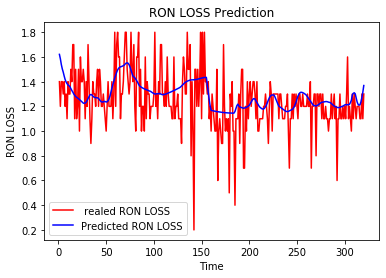

In [52]:
data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)
all_samples = data.iloc[: , : ].values  # 所有样本的特征作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
test_set_scaled_x = sc_x.fit_transform(all_samples[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_scaled_y = sc_y.fit_transform(all_samples[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化

x_test = []
y_test = []

for i in range(5, len(test_set_scaled_x)):
    x_test.append(test_set_scaled_x[i - 5:i, :])
    y_test.append(test_set_scaled_x[i, :])

# 将训练集由list格式变为array格式
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))

################## predict ######################
# 测试集输入模型进行预测
predicted_RON_LOSS = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_RON_LOSS = all_samples[5:,1:2]

# 画出真实数据和预测数据的对比曲线
plt.plot(range(320,0,-1),real_RON_LOSS.ravel(), color='red', label=' realed RON LOSS')
plt.plot(range(320,0,-1),predicted_RON_LOSS.ravel(), color='blue', label='Predicted RON LOSS')
plt.title('RON LOSS Prediction')
plt.xlabel('Time')
plt.ylabel('RON LOSS')
plt.legend()
plt.show()

In [31]:
real_RON_LOSS.shape

(320, 26)

In [33]:
predicted_RON_LOSS.shape

(320, 1)

In [ ]:
real_RON_LOSS = sc_y.inverse_transform(y_test)

In [34]:
y_test.shape

(320, 26)

In [36]:
x_test.shape

(320, 5, 26)

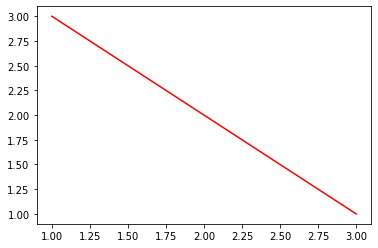

In [51]:
plt.plot(range(3,0,-1),[1,2,3], color='red', label=' realed RON LOSS')

-------------load the model-----------------
Train on 270 samples, validate on 45 samples
Epoch 1/50
270/270 [==============================] - 6s 21ms/sample - loss: 0.0232 - val_loss: 0.0151
Epoch 2/50
270/270 [==============================] - 0s 363us/sample - loss: 0.0231 - val_loss: 0.0155
Epoch 3/50
270/270 [==============================] - 0s 322us/sample - loss: 0.0233 - val_loss: 0.0152
Epoch 4/50
270/270 [==============================] - 0s 1ms/sample - loss: 0.0226 - val_loss: 0.0151
Epoch 5/50
270/270 [==============================] - 0s 337us/sample - loss: 0.0225 - val_loss: 0.0165
Epoch 6/50
270/270 [==============================] - 0s 326us/sample - loss: 0.0210 - val_loss: 0.0172
Epoch 7/50
270/270 [==============================] - 0s 333us/sample - loss: 0.0205 - val_loss: 0.0157
Epoch 8/50
270/270 [==============================] - 0s 322us/sample - loss: 0.0229 - val_loss: 0.0180
Epoch 9/50
270/270 [==============================] - 0s 422us/sample - loss: 0.0

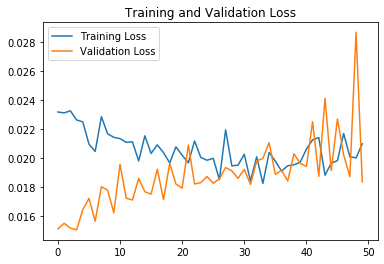

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)


training_set = data.iloc[0:325 - 50, : ].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = data.iloc[325 - 50: , : ].values  # 后50天的开盘价作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled_x = sc_x.fit_transform(training_set[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
training_set_scaled_y = sc_y.fit_transform(training_set[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_x = sc_x.transform(test_set[:,2:])  # 利用训练集的属性对测试集进行归一化
test_set_y = sc_y.transform(test_set[:,1:2])  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []


# 测试集：csv表格中前325-50=275个数据
# 利用for循环，遍历整个训练集，提取训练集中连续5天的26个降维新变量作为输入特征x_train，第6天的RON_LOSS作为标签，for循环共构建325-50-5=270组数据。

for i in range(5, len(training_set_scaled_x)):
    x_train.append(training_set_scaled_x[i - 5:i, :])
    y_train.append(training_set_scaled_y[i, :])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即270组数据；输入连续5个的26个降维新变量，预测出第6天的RON_LOSS，循环核时间展开步数为5; 每个时间步送入的特征是连续5天的26个降维新变量，有26个数据，故每个时间步输入特征个数为26
x_train = np.reshape(x_train, (x_train.shape[0], 5, 26))
# 测试集：csv表格中后50天数据
# 利用for循环，遍历整个测试集，提取测试集中连续5天的26个降维新变量作为输入特征x_train，第6天的数据作为RON_LOSS，for循环共构建50-5=45组数据。
for i in range(5, len(test_set_x)):
    x_test.append(test_set_x[i - 5 : i, :])
    y_test.append(test_set_y[i, :])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))


model = tf.keras.Sequential([
    LSTM(80, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
#C:\Users\Administrator\Desktop\
checkpoint_save_path = r"C:\Users\Administrator\Desktop\LSTMcheckpoint\LSTM_RON_LOSS.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()



file = open('C:/Users/Administrator/Desktop/LSTM_RON_LOSS_weights.txt', 'w' )  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

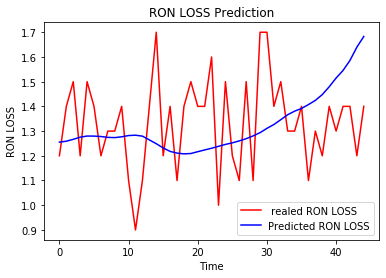

In [3]:

################## predict ######################
# 测试集输入模型进行预测
predicted_RON_LOSS = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_RON_LOSS = sc_y.inverse_transform(y_test)
# 画出真实数据和预测数据的对比曲线
plt.plot(real_RON_LOSS, color='red', label=' realed RON LOSS')
plt.plot(predicted_RON_LOSS, color='blue', label='Predicted RON LOSS')
plt.title('RON LOSS Prediction')
plt.xlabel('Time')
plt.ylabel('RON LOSS')
plt.legend()
plt.show()



In [4]:

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_RON_LOSS, real_RON_LOSS)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_RON_LOSS, real_RON_LOSS))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_RON_LOSS, real_RON_LOSS)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.047033
均方根误差: 0.216870
平均绝对误差: 0.184175


In [10]:
real_RON_LOSS = pd.DataFrame(real_RON_LOSS)
predicted_RON_LOSS = pd.DataFrame(predicted_RON_LOSS)
w = pd.concat([real_RON_LOSS,predicted_RON_LOSS] ,axis = 1)
w.to_csv(r"C:\Users\Administrator\Desktop\RON_VS_Pre.csv")

In [14]:
w

,0,0
0,1.2,1.255261
1,1.4,1.258940
2,1.5,1.266589
3,1.2,1.275397
4,1.5,1.279899
5,1.4,1.279688
6,1.2,1.277994
7,1.3,1.274536
8,1.3,1.273638
9,1.4,1.276803


In [15]:
w.shape

(45, 2)

In [16]:
w.to_csv(r"C:\Users\Administrator\Desktop\RON_VS_Pre.csv")

In [2]:
import pandas as pd
data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data

,id,P_RON_LOSS,var1,var2,var3,var4,var5,var6,var7,var8,...,var7.1,var18,var19,var20,var21,var22,var23,var24,var25,var26
0,1,1.4,-4.410000e+19,-9.270000e+19,4.640000e+19,1.740000e+19,-2.110000e+18,5.750000e+18,1.290000e+18,1.530000e+18,...,5.790000e+16,1.130000e+16,-2.850000e+15,-6.090000e+15,5.750000e+16,-8.060000e+15,-5.820000e+16,-6.790000e+15,8.110000e+16,2.880000e+15
1,2,1.2,-4.640000e+19,-9.020000e+19,4.500000e+19,1.680000e+19,-2.100000e+18,5.320000e+18,1.320000e+18,1.590000e+18,...,6.250000e+16,3.370000e+15,1.570000e+16,1.170000e+14,3.520000e+16,1.690000e+16,-4.600000e+16,3.610000e+15,6.620000e+16,6.350000e+15
2,3,1.4,-4.740000e+19,-8.910000e+19,4.440000e+19,1.660000e+19,-2.090000e+18,5.120000e+18,1.310000e+18,1.590000e+18,...,5.850000e+16,4.240000e+15,1.510000e+16,-1.140000e+15,3.070000e+16,1.830000e+16,-3.950000e+16,4.190000e+15,5.770000e+16,6.170000e+15
3,4,1.4,-4.960000e+19,-8.660000e+19,4.300000e+19,1.610000e+19,-2.070000e+18,4.640000e+18,1.310000e+18,1.610000e+18,...,4.860000e+16,1.140000e+16,1.220000e+16,-7.100000e+15,1.990000e+16,2.300000e+16,-2.220000e+16,6.560000e+15,3.270000e+16,4.740000e+15
4,5,1.3,-5.060000e+19,-8.560000e+19,4.240000e+19,1.580000e+19,-2.050000e+18,4.430000e+18,1.300000e+18,1.600000e+18,...,4.530000e+16,1.430000e+16,8.190000e+15,-1.130000e+16,1.730000e+16,2.280000e+16,-1.560000e+16,6.430000e+15,2.380000e+16,3.330000e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,321,1.1,2.610000e+19,1.220000e+20,1.210000e+20,-5.470000e+18,2.930000e+17,-2.250000e+17,2.350000e+18,-1.050000e+18,...,-2.290000e+16,-4.240000e+15,-8.490000e+16,5.850000e+14,-5.620000e+16,5.020000e+16,-5.220000e+16,-5.970000e+16,-7.330000e+15,-6.010000e+14
321,322,1.3,2.440000e+19,1.220000e+20,1.200000e+20,-4.860000e+18,7.570000e+17,-4.100000e+17,4.150000e+18,-1.860000e+18,...,-5.700000e+15,-3.400000e+14,-5.540000e+16,-2.950000e+14,-4.010000e+16,3.830000e+16,-4.070000e+16,-4.880000e+16,-8.320000e+15,-1.500000e+15
322,323,1.3,2.180000e+19,1.210000e+20,1.180000e+20,-3.970000e+18,1.440000e+18,-6.910000e+17,6.820000e+18,-3.050000e+18,...,1.550000e+16,3.210000e+15,1.390000e+16,-2.540000e+14,3.620000e+14,1.860000e+15,-8.150000e+15,-8.010000e+15,-1.220000e+15,-1.010000e+15
323,324,1.3,2.000000e+19,1.210000e+20,1.170000e+20,-3.380000e+18,1.890000e+18,-8.670000e+17,8.570000e+18,-3.840000e+18,...,3.500000e+16,6.800000e+15,7.600000e+16,5.230000e+14,4.030000e+16,-3.040000e+16,2.680000e+16,3.060000e+16,4.080000e+15,-4.770000e+14


In [3]:
w = data
w["id1"] = 321 - w["id"]
w

,id,P_RON_LOSS,var1,var2,var3,var4,var5,var6,var7,var8,...,var18,var19,var20,var21,var22,var23,var24,var25,var26,id1
0,1,1.4,-4.410000e+19,-9.270000e+19,4.640000e+19,1.740000e+19,-2.110000e+18,5.750000e+18,1.290000e+18,1.530000e+18,...,1.130000e+16,-2.850000e+15,-6.090000e+15,5.750000e+16,-8.060000e+15,-5.820000e+16,-6.790000e+15,8.110000e+16,2.880000e+15,320
1,2,1.2,-4.640000e+19,-9.020000e+19,4.500000e+19,1.680000e+19,-2.100000e+18,5.320000e+18,1.320000e+18,1.590000e+18,...,3.370000e+15,1.570000e+16,1.170000e+14,3.520000e+16,1.690000e+16,-4.600000e+16,3.610000e+15,6.620000e+16,6.350000e+15,319
2,3,1.4,-4.740000e+19,-8.910000e+19,4.440000e+19,1.660000e+19,-2.090000e+18,5.120000e+18,1.310000e+18,1.590000e+18,...,4.240000e+15,1.510000e+16,-1.140000e+15,3.070000e+16,1.830000e+16,-3.950000e+16,4.190000e+15,5.770000e+16,6.170000e+15,318
3,4,1.4,-4.960000e+19,-8.660000e+19,4.300000e+19,1.610000e+19,-2.070000e+18,4.640000e+18,1.310000e+18,1.610000e+18,...,1.140000e+16,1.220000e+16,-7.100000e+15,1.990000e+16,2.300000e+16,-2.220000e+16,6.560000e+15,3.270000e+16,4.740000e+15,317
4,5,1.3,-5.060000e+19,-8.560000e+19,4.240000e+19,1.580000e+19,-2.050000e+18,4.430000e+18,1.300000e+18,1.600000e+18,...,1.430000e+16,8.190000e+15,-1.130000e+16,1.730000e+16,2.280000e+16,-1.560000e+16,6.430000e+15,2.380000e+16,3.330000e+15,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,321,1.1,2.610000e+19,1.220000e+20,1.210000e+20,-5.470000e+18,2.930000e+17,-2.250000e+17,2.350000e+18,-1.050000e+18,...,-4.240000e+15,-8.490000e+16,5.850000e+14,-5.620000e+16,5.020000e+16,-5.220000e+16,-5.970000e+16,-7.330000e+15,-6.010000e+14,0
321,322,1.3,2.440000e+19,1.220000e+20,1.200000e+20,-4.860000e+18,7.570000e+17,-4.100000e+17,4.150000e+18,-1.860000e+18,...,-3.400000e+14,-5.540000e+16,-2.950000e+14,-4.010000e+16,3.830000e+16,-4.070000e+16,-4.880000e+16,-8.320000e+15,-1.500000e+15,-1
322,323,1.3,2.180000e+19,1.210000e+20,1.180000e+20,-3.970000e+18,1.440000e+18,-6.910000e+17,6.820000e+18,-3.050000e+18,...,3.210000e+15,1.390000e+16,-2.540000e+14,3.620000e+14,1.860000e+15,-8.150000e+15,-8.010000e+15,-1.220000e+15,-1.010000e+15,-2
323,324,1.3,2.000000e+19,1.210000e+20,1.170000e+20,-3.380000e+18,1.890000e+18,-8.670000e+17,8.570000e+18,-3.840000e+18,...,6.800000e+15,7.600000e+16,5.230000e+14,4.030000e+16,-3.040000e+16,2.680000e+16,3.060000e+16,4.080000e+15,-4.770000e+14,-3


In [13]:
w["p"] = w.index
w["k"] = 100 + w['p']
w

,id,P_RON_LOSS,var1,var2,var3,var4,var5,var6,var7,var8,...,var20,var21,var22,var23,var24,var25,var26,id1,p,k
0,1,1.4,-4.410000e+19,-9.270000e+19,4.640000e+19,1.740000e+19,-2.110000e+18,5.750000e+18,1.290000e+18,1.530000e+18,...,-6.090000e+15,5.750000e+16,-8.060000e+15,-5.820000e+16,-6.790000e+15,8.110000e+16,2.880000e+15,320,0,100
1,2,1.2,-4.640000e+19,-9.020000e+19,4.500000e+19,1.680000e+19,-2.100000e+18,5.320000e+18,1.320000e+18,1.590000e+18,...,1.170000e+14,3.520000e+16,1.690000e+16,-4.600000e+16,3.610000e+15,6.620000e+16,6.350000e+15,319,1,101
2,3,1.4,-4.740000e+19,-8.910000e+19,4.440000e+19,1.660000e+19,-2.090000e+18,5.120000e+18,1.310000e+18,1.590000e+18,...,-1.140000e+15,3.070000e+16,1.830000e+16,-3.950000e+16,4.190000e+15,5.770000e+16,6.170000e+15,318,2,102
3,4,1.4,-4.960000e+19,-8.660000e+19,4.300000e+19,1.610000e+19,-2.070000e+18,4.640000e+18,1.310000e+18,1.610000e+18,...,-7.100000e+15,1.990000e+16,2.300000e+16,-2.220000e+16,6.560000e+15,3.270000e+16,4.740000e+15,317,3,103
4,5,1.3,-5.060000e+19,-8.560000e+19,4.240000e+19,1.580000e+19,-2.050000e+18,4.430000e+18,1.300000e+18,1.600000e+18,...,-1.130000e+16,1.730000e+16,2.280000e+16,-1.560000e+16,6.430000e+15,2.380000e+16,3.330000e+15,316,4,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,321,1.1,2.610000e+19,1.220000e+20,1.210000e+20,-5.470000e+18,2.930000e+17,-2.250000e+17,2.350000e+18,-1.050000e+18,...,5.850000e+14,-5.620000e+16,5.020000e+16,-5.220000e+16,-5.970000e+16,-7.330000e+15,-6.010000e+14,0,320,420
321,322,1.3,2.440000e+19,1.220000e+20,1.200000e+20,-4.860000e+18,7.570000e+17,-4.100000e+17,4.150000e+18,-1.860000e+18,...,-2.950000e+14,-4.010000e+16,3.830000e+16,-4.070000e+16,-4.880000e+16,-8.320000e+15,-1.500000e+15,-1,321,421
322,323,1.3,2.180000e+19,1.210000e+20,1.180000e+20,-3.970000e+18,1.440000e+18,-6.910000e+17,6.820000e+18,-3.050000e+18,...,-2.540000e+14,3.620000e+14,1.860000e+15,-8.150000e+15,-8.010000e+15,-1.220000e+15,-1.010000e+15,-2,322,422
323,324,1.3,2.000000e+19,1.210000e+20,1.170000e+20,-3.380000e+18,1.890000e+18,-8.670000e+17,8.570000e+18,-3.840000e+18,...,5.230000e+14,4.030000e+16,-3.040000e+16,2.680000e+16,3.060000e+16,4.080000e+15,-4.770000e+14,-3,323,423


In [9]:
w.index

RangeIndex(start=0, stop=325, step=1)